In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
from tqdm.notebook import tqdm
# from tqdm import tqdm

In [2]:
def get_subset(dataset, indices, region):
    subset = []
    for i in indices:
        subset.append((dataset[i][region[0]], dataset[i][region[1]]))
    return subset

def slash_train_val(dataset, percentage):
    total = len(dataset)
    val_data = np.random.choice(list(range(total)),int(total*percentage), replace=False).tolist()
    train_data = list(set(range(total)) - set(val_data))
    return val_data, train_data

In [106]:
# dataSetFile: 2D numpy array, [# of moives, # of attributes]
# dataSetFile[0] --> 211 elements, [0:50] plot embeddings, [50:209] attributes, [209] IMDB rating, [210] Douban rating; Missing data = -1
dataSetFile = np.load("npAttrEmbOvwDoubanR.npy")

isMethod1 = True
if isMethod1:
    dataset = []
    for i in range(len(dataSetFile)):
        dataset.append((np.concatenate([dataSetFile[i,0:50]/1000, dataSetFile[i,50:209],dataSetFile[i,209:210]]), dataSetFile[i,210])) # data normalization
    # IMDBintersectDouban: 1D array, movie indices in dataSetFile that IMDB $\cap$ Douban
    IMDBintersectDouban = np.load("IMDBIntersectDouban.npy")
    dataset_intersect = get_subset(dataset, IMDBintersectDouban, [0,1])

    # IMDBintersectDouban: 1D array, movie indices in dataSetFile that IMDB $-$ Douban
    IMDBDifferenceDouban = np.load("IMDBDifferenceDouban.npy")
    dataset_difference = get_subset(dataset, IMDBDifferenceDouban, [0,1])
    
    dummy_rating = 0.
    for i in range(len(dataset_difference)):
        a = 1*dataset_difference[i][0][209:210]
                
        y = list(dataset_difference[i])
        y[1] = a
        dataset_difference[i] = tuple(y)
        dataset_difference[i][0][209:210] = dummy_rating
        #print(dataset_difference[i])



    percentage = 0.15 # percentage of the evaluation set

    # slash the three datasets into training and evaluation set
    train_total, val_total = slash_train_val(dataset, percentage)
    train_intersect, val_intersect = slash_train_val(dataset_intersect, percentage)
    train_difference, val_difference = slash_train_val(dataset_difference, percentage)
else:
    dataset = []
    for i in range(len(dataSetFile)):
        dataset.append((np.concatenate([dataSetFile[i,0:50]/1000, dataSetFile[i,50:209]]), dataSetFile[i,209], dataSetFile[i,210])) # data normalization

    # IMDBintersectDouban: 1D array, movie indices in dataSetFile that IMDB $\cap$ Douban
    IMDBintersectDouban = np.load("IMDBIntersectDouban.npy")
    dataset_intersect = get_subset(dataset, IMDBintersectDouban, [0,2])

    # IMDBintersectDouban: 1D array, movie indices in dataSetFile that IMDB $-$ Douban
    IMDBDifferenceDouban = np.load("IMDBDifferenceDouban.npy")
    dataset_difference = get_subset(dataset, IMDBDifferenceDouban, [0,1])

    percentage = 0.15 # percentage of the evaluation set

    # slash the three datasets into training and evaluation set
    train_total, val_total = slash_train_val(dataset, percentage)
    train_intersect, val_intersect = slash_train_val(dataset_intersect, percentage)
    train_difference, val_difference = slash_train_val(dataset_difference, percentage)

# sanity check
print(len(train_total))
print(len(val_total))

1276
7234


In [4]:
# The model we use
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        exp = 128
        emb1 = 10
        emb2 = 20 
        self.fc11 = torch.nn.Linear(50, emb1)
        self.fc12 = torch.nn.Linear(159, emb2)
        self.fc13 = torch.nn.Linear(1, 1)
        
        self.fc2 = nn.Linear(emb1+emb2+1, exp)
        self.fc3 = nn.Linear(exp, exp)
        self.fc4 = nn.Linear(exp,10)
        self.drop = torch.nn.Dropout(0.0)
        self.tail = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x1 = self.drop(self.relu(self.fc11(x[:,:50])))
        x2 = self.drop(self.relu(self.fc12(x[:,50:209])))
        x3 = self.drop(self.fc13(x[:,209:210]))

        x = torch.cat([x1,x2,x3],dim=1)
        x = self.drop(self.relu(self.fc2(x)))
        x = self.drop(self.relu(self.fc3(x)))
        return (self.tail(self.fc4(x)) * (torch.Tensor(list(range(1,11))).to(x.device))).sum(dim=1)

In [5]:
# Training and testing functions for pytorch
def train(epochs):
    loss_min = 10000
    iter_loader = tqdm(range(epochs))
    for _ in iter_loader:
        running_loss = 0.
        i = 0
        for data, labels in train_loader:
            # data = expand_data(data)
            data, labels = data.float().to(device), labels.to(device)
            # print(data[0], labels[0])
            # break
            optimizer.zero_grad()
            output = model(data)
            # print(output.size())
            loss = criteria(output, labels.view(output.size()).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            i += 1
        # print(running_loss/i)
        scheduler.step()
        val_loss = val()
        iter_loader.set_description(f"{running_loss/i:.4f}, {val_loss:.4f}, {loss_min:.4f}")
        if val_loss < loss_min:
            loss_min = val_loss

def val():
    running_loss = 0.
    i = 0
    for data, labels in val_loader:
        # data = expand_data(data)
        data, labels = data.float().to(device), labels.to(device)
        output = model(data)
        loss = criteria(output, labels.view(output.size()).float())
        running_loss += loss.item()
        i+=1
    return running_loss/i

## Baseline

In [42]:
# training and validation loader definition
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_intersect, train_intersect), batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_intersect, val_intersect), batch_size=1024, shuffle=False)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Net()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), 0.1, momentum=0.9, weight_decay=0.)
# optimizer = optim.Adam(model.parameters(), 0.1)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [40, 60, 80], 0.8)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [300, 600, 900], 0.1)
criteria = nn.MSELoss()
train(300)

### Baseline Experiment Log

1. 0.5759
2. 0.5799
3. 0.5621
4. 0.5809
5. 0.5668
6. 0.5650
7. 0.5800
8. 0.5970
9. 0.5812
10. 0.5696

## Transfer

In [118]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_difference, train_difference), batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_difference, val_difference), batch_size=1024, shuffle=False)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Net()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), 0.1, momentum=0.9, weight_decay=0.)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [300, 600, 900], 0.1)
criteria = nn.MSELoss()
train(80)
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_intersect, train_intersect), batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_intersect, val_intersect), batch_size=1024, shuffle=False)
criteria = nn.MSELoss()
train(400)

In [12]:
### Transfer Experiment Log
# Dummy from 10 to 0
import numpy as np
from matplotlib import pyplot as plt
results = np.array([
    [ 0.7434, 0.9122, 0.5614, 0.6050, 0.7922],
    [ 0.7883, 0.6051, 0.7863, 0.7953, 0.7238],
    [ 0.6023, 0.5829, 0.6209, 0.5828, 0.5941],
    [ 0.5996, 0.6643, 0.6754, 0.6413, 0.6284],
    [ 0.7778, 0.8221, 0.5897, 0.5838, 0.8313],
    [ 0.5475, 0.6244, 0.5576, 0.5408, 0.5596],
    [ 0.5587, 0.5641, 0.5684, 0.5684, 0.5623],
    [ 0.5927, 0.6364, 0.6037, 0.6037, 0.6364],
    [ 0.6093, 0.5988, 0.5695, 0.6039, 0.6277],
    [ 0.7500, 0.5535, 0.5578, 0.5623, 0.5652],
    [ 0.5564, 0.5637, 0.5995, 0.5636, 0.6034]
])
results = np.sqrt(results)
res_mean = results.mean(axis=1)[::-1]
res_std = results.std(axis=1)[::-1]

Text(0, 0.5, 'RMSE')

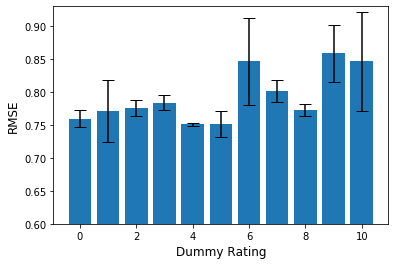

In [27]:
x_pos = np.arange(len(res_mean))
plt.bar(x_pos, res_mean, yerr=res_std, capsize=6)
plt.ylim(0.6,0.93)
plt.xlabel("Dummy Rating", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

## SVR Baseline

In [119]:
from sklearn import svm
TS = torch.utils.data.Subset(dataset_intersect, train_intersect)
VS = torch.utils.data.Subset(dataset_intersect, val_intersect)
train_loader = torch.utils.data.DataLoader(TS, batch_size=len(TS), shuffle=True)
val_loader = torch.utils.data.DataLoader(VS, batch_size=len(VS), shuffle=False)
for X,y in train_loader:
    pass
regr = svm.SVR(kernel="poly", degree=10, gamma="scale", tol=1e-4, verbose=True)
regr.fit(X, y)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=10, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.0001, verbose=True)

In [120]:
for X,y in val_loader:
    pass
T = regr.predict(X).astype("float32")
criteria(torch.Tensor(T), y)

tensor(0.7782, dtype=torch.float64)

In [32]:
np.sqrt(0.7782)

0.8821564487096379